
<a id='data-statistical-packages'></a>
How to read this lecture…

- If using QuantEcon lectures for the first time on a computer, execute `] add InstantiateFromURL` inside of a notebook or the REPL  
- For some notebooks, enable content with “Trust” on the command tab of Jupyter lab  
- Code should execute sequentially if run in a Jupyter notebook  
- Please direct feedback to [contact@quantecon.org](mailto:contact@quantecon.org") or [discourse forum](http://discourse.quantecon.org/)  

# The Julia Data and Statistical Ecosystem

## Contents

- [The Julia Data and Statistical Ecosystem](#The-Julia-Data-and-Statistical-Ecosystem)  
  - [Overview](#Overview)  
  - [DataFrames](#DataFrames)  
  - [Statistics](#Statistics)  

## Overview

This lecture explores some of the key packages for working with data and statistics in Julia

While Julia is not an ideal language for pure cookie-cutter statistical analysis, it has many useful packages to provide those tools as part of a more general solution

This list is not exhaustive, and others can be found in organizations such as [JuliaStats](https://github.com/JuliaStats) [JuliaData](https://github.com/JuliaData/), and  [QueryVerse](https://github.com/queryverse)

### Setup

In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLectureAllPackages", tag = "v0.1.2") # activate the QuantEcon environment

using LinearAlgebra, Statistics, Compat # load common packages

┌ Warning: On Windows, creating file symlinks requires Administrator privileges
└ @ Base.Filesystem file.jl:789


## DataFrames

A useful package for working with data is [DataFrames](https://github.com/JuliaStats/DataFrames.jl)

The most important data type provided is a `DataFrame`, a two dimensional array for storing heterogeneous data

Although data can be heterogeneous within a `DataFrame`, the contents of the columns must be homogeneous

This is analogous to a `data.frame` in R, a `DataFrame` in Pandas (Python) or, more loosely, a spreadsheet in Excel

There are a few different ways to create a DataFrame

### Constructing a DataFrame

The first is to setup columns and construct a dataframe by assigning names

In [2]:
using DataFrames, RDatasets  # RDatasets provides good standard data examples from R

# note use of missing
commodities = ["crude", "gas", "gold", "silver"]
last_price = [4.2, 11.3, 12.1, missing]
df = DataFrame(commod = commodities, price = last_price)

4×2 DataFrame
│ Row │ commod │ price    │
│     │ String │ Float64⍰ │
├─────┼────────┼──────────┤
│ 1   │ crude  │ 4.2      │
│ 2   │ gas    │ 11.3     │
│ 3   │ gold   │ 12.1     │
│ 4   │ silver │ missing  │

Columns of the DataFrame can be accessed by name using a symbol or a `.`

In [3]:
df[:price]

4-element Array{Union{Missing, Float64},1}:
  4.2     
 11.3     
 12.1     
   missing

In [4]:
df.price

4-element Array{Union{Missing, Float64},1}:
  4.2     
 11.3     
 12.1     
   missing

Note that the type of this array has values `Union{Missing, Float64}` since it was created with a `missing` value

In [5]:
df.commod

4-element Array{String,1}:
 "crude" 
 "gas"   
 "gold"  
 "silver"

The DataFrames package provides a number of methods for acting on DataFrames, such as `describe`

In [6]:
describe(df)

2×8 DataFrame. Omitted printing of 1 columns
│ Row │ variable │ mean   │ min   │ median │ max    │ nunique │ nmissing │
│     │ Symbol   │ Union… │ Any   │ Union… │ Any    │ Union…  │ Union…   │
├─────┼──────────┼────────┼───────┼────────┼────────┼─────────┼──────────┤
│ 1   │ commod   │        │ crude │        │ silver │ 4       │          │
│ 2   │ price    │ 9.2    │ 4.2   │ 11.3   │ 12.1   │         │ 1        │

While often data will be generated all at once, or read from a file, you can add to a dataframe by providing the key parameters

In [7]:
nt = (commod = "nickel", price= 5.1)
push!(df, nt)

5×2 DataFrame
│ Row │ commod │ price    │
│     │ String │ Float64⍰ │
├─────┼────────┼──────────┤
│ 1   │ crude  │ 4.2      │
│ 2   │ gas    │ 11.3     │
│ 3   │ gold   │ 12.1     │
│ 4   │ silver │ missing  │
│ 5   │ nickel │ 5.1      │

Named tuples can also be used to construct a DataFrame, and have it properly deduce all types

In [8]:
nt = (t = 1, col1 = 3.0)
df2 = DataFrame([nt])
push!(df2, (t=2, col1 = 4.0))

2×2 DataFrame
│ Row │ t     │ col1    │
│     │ Int64 │ Float64 │
├─────┼───────┼─────────┤
│ 1   │ 1     │ 3.0     │
│ 2   │ 2     │ 4.0     │

### Working with Missing

As we discussed in [fundamental types](missing), the semantics of `missing` are that mathematical operations will not silently ignore it

In order to allow `missing` in a column, you can create/load the dataframe from a source with missings, or call `allowmissing!` on a column

In [9]:
allowmissing!(df2, :col1) # necessary to add in a for col1
push!(df2, (t=3, col1 = missing))
push!(df2, (t=4, col1 = 5.1))

4×2 DataFrame
│ Row │ t     │ col1     │
│     │ Int64 │ Float64⍰ │
├─────┼───────┼──────────┤
│ 1   │ 1     │ 3.0      │
│ 2   │ 2     │ 4.0      │
│ 3   │ 3     │ missing  │
│ 4   │ 4     │ 5.1      │

We can see the propagation of `missing` to caller functions, as well the way to efficiently calculate with non-missing data

In [10]:
@show mean(df2.col1)
@show mean(skipmissing(df2.col1))

mean(df2.col1) = missing
mean(skipmissing(df2.col1)) = 4.033333333333333


4.033333333333333

And to replace the missing,

In [11]:
df2.col1  .= coalesce.(df2.col1, 0.0) # replace all missing with 0.0

4-element Array{Union{Missing, Float64},1}:
 3.0
 4.0
 0.0
 5.1

### Manipulating and Transforming DataFrames

One way to do an additional calculation with a DataFrame is the `@transform` macro from `DataFramesMeta.jl`

In [12]:
using DataFramesMeta
f(x) = x^2
df2 = @transform(df2, col2 = f.(:col1))

4×3 DataFrame
│ Row │ t     │ col1     │ col2    │
│     │ Int64 │ Float64⍰ │ Float64 │
├─────┼───────┼──────────┼─────────┤
│ 1   │ 1     │ 3.0      │ 9.0     │
│ 2   │ 2     │ 4.0      │ 16.0    │
│ 3   │ 3     │ 0.0      │ 0.0     │
│ 4   │ 4     │ 5.1      │ 26.01   │

### Categorical Data

For data that is [categorical](https://juliadata.github.io/DataFrames.jl/stable/man/categorical.html#Categorical-Data-1)

In [13]:
using CategoricalArrays
id = [1, 2, 3, 4]
y = ["old", "young", "young", "old"]
y = CategoricalArray(y)
df = DataFrame(id=id, y=y)

4×2 DataFrame
│ Row │ id    │ y            │
│     │ Int64 │ Categorical… │
├─────┼───────┼──────────────┤
│ 1   │ 1     │ old          │
│ 2   │ 2     │ young        │
│ 3   │ 3     │ young        │
│ 4   │ 4     │ old          │

In [14]:
levels(df.y)

2-element Array{String,1}:
 "old"  
 "young"

### Visualization, Querying, and Plots

The DataFrame (and similar types that fulfill a standard generic interface) can fit into a variety of packages

One set of them is the [QueryVerse](https://github.com/queryverse)

**Note:** The queryverse, in the same spirit as R’s tidyverse, makes heavy use of the pipeline syntax `|>`

In [15]:
x = 3.0
f(x) = x^2
g(x) = log(x)

@show g(f(x))
@show x |> f |> g; # pipes nest function calls

g(f(x)) = 2.1972245773362196
(x |> f) |> g = 2.1972245773362196


To give an example directly from the source of the LINQ inspired [Query.jl](http://www.queryverse.org/Query.jl/stable/)

In [16]:
using Query

df = DataFrame(name=["John", "Sally", "Kirk"], age=[23., 42., 59.], children=[3,5,2])

x = @from i in df begin
    @where i.age>50
    @select {i.name, i.children}
    @collect DataFrame
end

1×2 DataFrame
│ Row │ name   │ children │
│     │ String │ Int64    │
├─────┼────────┼──────────┤
│ 1   │ Kirk   │ 2        │

While it is possible to to just use the `Plots.jl` library, there may be better options for displaying tabular data–such as [Vegalite.jl](http://fredo-dedup.github.io/VegaLite.jl/latest/)

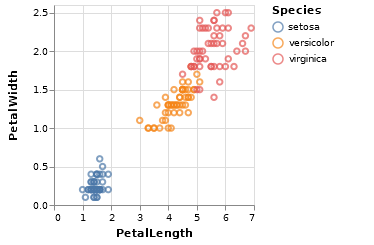

In [17]:
using RDatasets, VegaLite
iris = dataset("datasets", "iris")

iris |> @vlplot(
    :point,
    x=:PetalLength,
    y=:PetalWidth,
    color=:Species
)

Another useful tool for exploring tabular data is [DataVoyager.jl](https://github.com/queryverse/DataVoyager.jl)

In [18]:
using DataVoyager
iris |> Voyager()

Voyager(Electron.Window(Application(Base.PipeEndpoint(Base.Libc.WindowsRawSocket(0x0000000000000590) open, 0 bytes waiting), Process(`'C:\Users\jlperla\.julia\packages\Electron\IV1np\src\..\deps\electron\electron.exe' 'C:\Users\jlperla\.julia\packages\Electron\IV1np\src\main.js' '\\.\pipe\juliaelectron-7580-1' '\\.\pipe\juliaelectron-sysnotify-7580-1' FkuwVNL16I0tjRMB9oDHbypdTs739sj+Z4hnGjceBBpAmdOmbsHeGJFiiRocGpi5dvlhxSaJES85+M9v0brIXtdrOWBeu6MMpmeRnYn5DXzDzURJEPqgt8e5IbFMd50lPjtN/003DTTICy/B4of6ubjub5Tq5XvNQZB9esOue+w=`, ProcessRunning), [1 window]), 1, true, Channel{Any}(sz_max:128,sz_curr:0)))

The `Voyager()` function creates a separate window for analysis

## Statistics

While Julia is not intended as a replacement for R, Stata, and similar specialty languages, it has a growing

### General Linear Linear Models

Many of the packages live in the [JuliaStats organization](https://github.com/JuliaStats/)

A few to point out

- [StatsBase](https://github.com/JuliaStats/StatsBase.jl) has basic statistical functions such as geometric and harmonic means, auto-correlations, robust statistics, etc.  
- [StatSFuns](https://github.com/JuliaStats/StatsFuns.jl) has a variety of mathematical functions and constants such as pdf and cdf of many distributions, softmax, etc.  


To run linear regressions and similar statistics, use the [GLM](http://juliastats.github.io/GLM.jl/latest/) package

In [19]:
using GLM

x = randn(100)
y = 0.9 .* x + 0.5 * rand(100)
df = DataFrame(x=x, y=y)
ols = lm(@formula(y ~ x), df) # R-style notation

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)  0.251253 0.0135154 18.5901   <1e-33
x            0.913107 0.0151731 60.1792   <1e-78


To display the results in a useful tables for LaTex and the display, use [RegressionTables](https://github.com/jmboehm/RegressionTables.jl/) for output similar to the Stata package esttab and the R package stargazer.

In [20]:
using RegressionTables
regtable(ols)
# regtable(ols,  renderSettings = latexOutput()) # for LaTex output


----------------------
                  y   
              --------
                   (1)
----------------------
(Intercept)   0.251***
               (0.014)
x             0.913***
               (0.015)
----------------------
Estimator          OLS
----------------------
N                  100
R2               0.974
----------------------




### Fixed Effects

While Julia may be overkill for estimating a simple linear regression, fixed-effect estimation with dummies for multiple variables are much more computationally intensive

For a 2-way fixed-effect, taking the example directly from the documentation using [cigarette consumption data](https://github.com/johnmyleswhite/RDatasets.jl/blob/master/doc/plm/rst/Cigar.rst)

In [23]:
using FixedEffectModels
cigar = dataset("plm", "Cigar")
cigar.StateCategorical =  categorical(cigar.State)
cigar.YearCategorical =  categorical(cigar.Year)
fixedeffectresults = reg(cigar, @model(Sales ~ NDI, fe = StateCategorical + YearCategorical, weights = Pop, vcov = cluster(StateCategorical)))
regtable(fixedeffectresults)


----------------------------
                     Sales  
                   ---------
                         (1)
----------------------------
NDI                -0.005***
                     (0.001)
----------------------------
StateCategorical         Yes
YearCategorical          Yes
----------------------------
Estimator                OLS
----------------------------
N                      1,380
R2                     0.804
----------------------------




To explore the data use the interactive DataVoyager

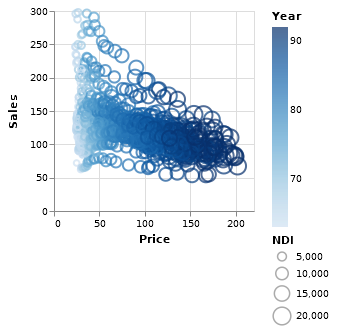

In [22]:
cigar |> Voyager()

cigar |> @vlplot(
    :point,
    x=:Price,
    y=:Sales,
    color=:Year,
    size=:NDI
)